In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from helpers.mv_single_binary import majority_voting
import helpers.algorithms_utils as alg_utils
from helpers.truth_finder_single import truth_finder_single
from helpers.truth_finder import expectation_maximization
import helpers.dawid_skene as dawid_skene
import multiprocessing
import time
import matplotlib.pyplot as plt


In [300]:
from helpers.mv_single_binary import majority_voting
from algorithms.smart_stop import decision_function_em
from algorithms.smart_stop import decision_function_mv
from algorithms.smart_stop import decision_function_bayes
from algorithms.smart_stop import decision_function_mv_base

%time

def worker_vote(gt, i, acc):
    if np.random.binomial(1, acc):
        vote = gt[i]
    else:
        vote = 1 - gt[i]
        
    return vote

acc = .75
items_num = 1000
th = .8
cr = 1/5
votes_num = 3

gt = alg_utils.generate_gold_data(items_num, .5)
cf = majority_voting
df = decision_function_mv


t_l = []
t_r = []
t_p = []

for _ in range(10):

    workers_accuracy = alg_utils.simulate_workers(1000, 0, True, acc, base_acc = .5)
    votes = {i:{} for i in range(items_num)}
    votes = {x:{val:[alg_utils.get_worker_vote(workers_accuracy, x, gt, votes)[1]] for val in np.arange(0, votes_num, 1)} for x in range(items_num)} 
    must_get_more_votes = True
    
    results = df(items_num, votes, th, cr, cf)
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    must_get_more_votes = len(items_predicted_classified) > 0

    while(must_get_more_votes):

        total_votes_aux = {}
        for i, v in items_predicted_classified.items():           
            worker_id, vote = alg_utils.get_worker_vote(workers_accuracy, i, gt, votes)

            votes[i][worker_id] = [vote]

            total_votes_aux[i] = votes[i]
        #end for

        results = df(len(items_predicted_classified), total_votes_aux, th, cr, cf)

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        #print(len(items_predicted_classified))
        must_get_more_votes = len(items_predicted_classified) > 0

    #print(votes)

    items_classification = alg_utils.classify_items(votes, gt, cf, .5)

    print("----")


    loss, recall, precision =alg_utils.Metrics.compute_metrics(items_classification, gt, 5)
    t_l.append(loss)
    t_r.append(recall)
    t_p.append(precision)
    
print(np.mean(t_l))
print(np.mean(t_r))
print(np.mean(t_p))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 596 µs
----
----
----


KeyboardInterrupt: 

In [9]:
.75
0.169
0.95
0.9171729912566118
--
.85
0.195
0.9380000000000001
0.9216768105081089
--
.95
0.048
0.982
0.9939983993597439

'''
.8
mv-mv
0.184
0.9592
0.8556714703885876
mv-bayes
0.1468
0.9508
0.9523127645944451
mv-em
0.2144
0.9396
0.8829743958123392
tf-em
0.451
0.8484
0.857014992134125
tf-bayes
0.41440000000000005
0.8611999999999999
0.8663151858194605
'''


'\nmv-bayes\n0.1468\n0.9508\n0.9523127645944451\nmv-em\n0.2144\n0.9396\n0.8829743958123392\ntf-em\n0.451\n0.8484\n0.857014992134125\ntf-bayes\n0.41440000000000005\n0.8611999999999999\n0.8663151858194605\n'

In [122]:
#20,31,45    ///13-25
i = 13
Psi = alg_utils.input_adapter_single(votes[i])
print(votes[i])
print(gt[i])
truth_finder_single(Psi)

{0: [1], 1: [0], 2: [0], 3: [1], 4: [1], 884: [0], 567: [1], 82: [0], 771: [1], 152: [0], 524: [1], 729: [0], 861: [0]}
1


2.2534749635520452e-37

In [24]:
Psi = alg_utils.input_adapter_single(votes[9])
print(Psi)
truth_finder_single(Psi)

[[(0, 0), (1, 1), (2, 1), (3, 1)]]


0.9999999999999993

In [16]:
x = [np.random.binomial(1, .3) for x in range(100)]
np.mean(x)

0.26

In [193]:
def em_adapter(votes):
    N = len(votes[1].keys())
    M = 2
    Psi = alg_utils.input_adapter(votes)
    return N, M, Psi
adapter = em_adapter
votes = {
    0: {0: [1], 1: [0], 2: [0]},
    1: {}
}
#N, M, Psi = adapter(votes)
#print(adapter(votes))
expectation_maximization(3, 2, alg_utils.input_adapter(votes))
#print(p)

([3.064248402684539e-07, 0.9999996935751597, 0.9999996935751597],
 [defaultdict(float, {1: 3.064248402684539e-07, 0: 0.9999996935751597}),
  defaultdict(float, {})])

In [14]:
ins = [np.random.binomial(1, 0.3) for x in range(1000)]
outs = [np.random.binomial(1, 0.7) for x in range(1000)]
print(np.mean(ins))
print(np.mean(outs))

0.29
0.68


In [148]:
np.random.binomial(1, 0.3)

0

In [2]:
v = {3: [1], 5: [0], 1: [0]}
alg_utils.input_adapter_single(v)

[[(0, 1), (1, 0), (2, 0)]]

In [ ]:
print(range(0, len(a), ))

In [35]:
v = {
    0:{0: [1], 1: [1], 2: [1], 3:[1]},
    1:{0: [1], 1: [1], 2: [1], 3:[0]},
    2:{0: [1], 1: [0], 2: [0], 3:[0]}
}
#expectation_maximization(4, 2, alg_utils.input_adapter(v))
cf = majority_voting
ct = .9
r = {i:(((1 - ct) <= cf(alg_utils.input_adapter_single(i_votes)) <= ct)) for i, i_votes in v.items()}
print(r)
f = [i for i, d in r.items() if d == True]
for a in f:
    print(a)

{0: False, 1: True, 2: True}
1
2


In [19]:
from helpers.truth_finder import expectation_maximization
from helpers.dawid_skene import dawid_skene
import helpers.algorithms_utils as alg_utils
import numpy as np

v = {
    2:{0: [1], 1: [1], 2: [0]},
    11:{0: [1], 1: [1], 2: [1]},
    3:{0: [0], 1: [0], 2: [0]},
    5:{0: [1], 1: [0], 2: [0]}
}

#ds = dawid_skene(v)
votes = alg_utils.input_adapter(v)

dong = expectation_maximization(3, 4, votes)

#print(ds)
#print(np.mean(dong[0]))
print(dong)

([0.75, 0.9980392156862745, 0.75], [defaultdict(<class 'float'>, {1: 0.996078431372549, 0: 0.0039215686274509725}), defaultdict(<class 'float'>, {1: 1.0}), defaultdict(<class 'float'>, {0: 1.0}), defaultdict(<class 'float'>, {1: 0.0039215686274509725, 0: 0.996078431372549})])


In [224]:
'''
P(positive|evidence) = P(evidence|positive) P(positive) / P(evidence)
= P(evidence|positive) P(positive) / P(evidence|positive) P(positive) + P(evidence|negative) P(negative)
'''
from helpers.truth_finder import expectation_maximization
from scipy.stats import binom
import math

#acc = .66
prior = .5

a = 1
b = 5

v = {
    0:{0: [1], 1: [1], 2: [0]},
    1:{0: [1], 1: [1], 2: [1]},
    2:{0: [0], 1: [0], 2: [0]},
    3:{0: [1], 1: [0], 2: [0]}
}

accs, p = expectation_maximization(3, 4, alg_utils.input_adapter(v))

acc = np.mean(accs)

like_in = binom.pmf(a, a+b, acc)
like_out = binom.pmf(b, a+b, acc)

p_v_pos = math.pow(acc, a) * math.pow(1 - acc, b)
p_v_neg = math.pow(acc, b) * math.pow(1 - acc, a)
#print(like_in)
#print(like_out)
#print(p_v_pos)
#print(p_v_neg)

#print( ((p_v_pos * prior) / ((p_v_pos * prior) + (p_v_neg * (1 - prior)))) )
print( ((like_in * prior) / ((like_in * prior) + (like_out * (1 - prior)))) )


0.0016277011551087206


In [113]:
import numpy as np
print_table_columns = ["Threshold", "Cost mean","Cost Std", "TC mean", "TC std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
smv_mix = pd.DataFrame({}, columns=print_table_columns)
smv_mix["Loss lr=5"] = []
smv_mix["Name"] = []

smv_mix.loc[0] = [.5, \
             ba_lr1["Cost mean"][0], ba_lr1["Cost Std"][0], \
             ba_lr1["TC mean"][0], ba_lr1["TC std"][0], \
             ba_lr1["Loss mean"][0], ba_lr1["Loss Std"][0], \
             ba_lr1["Recall mean"][0], ba_lr1["Recall Std"][0],\
             ba_lr1["Precision mean"][0], ba_lr1["Precision Std"][0], \
             ba_lr5["Loss mean"][0], "Brown&Allison"]

smv_mix.loc[1] = [.5, \
             mv_base_lr1["Cost mean"][0], mv_base_lr1["Cost Std"][0], \
             mv_base_lr1["TC mean"][0], mv_base_lr1["TC std"][0], \
             mv_base_lr1["Loss mean"][0], mv_base_lr5["Loss Std"][0], \
             mv_base_lr1["Recall mean"][0], mv_base_lr1["Recall Std"][0],\
             mv_base_lr1["Precision mean"][0], mv_base_lr1["Precision Std"][0], \
             mv_base_lr5["Loss mean"][0], "MV Baseline"]

smv_lr1 = pd.read_csv('./results/it50_d50_b5_lr1/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')
smv_lr5 = pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')

idx = 2
for key in range(5):
    smv_mix.loc[idx] = [np.mean([smv_lr1["Threshold"][key], smv_lr5["Threshold"][key]]), \
             np.mean([smv_lr1["Cost mean"][key], smv_lr5["Cost mean"][key]]), \
             np.mean([smv_lr1["Cost Std"][key], smv_lr5["Cost Std"][key]]), \
             np.mean([smv_lr1["TC mean"][key], smv_lr5["TC mean"][key]]), \
             np.mean([smv_lr1["TC std"][key], smv_lr5["TC std"][key]]), \
             smv_lr1["Loss mean"][key], \
             np.mean([smv_lr1["Loss Std"][key], smv_lr5["Loss Std"][key]]), \
             np.mean([smv_lr1["Recall mean"][key], smv_lr5["Recall mean"][key]]), \
             np.mean([smv_lr1["Recall Std"][key], smv_lr5["Recall Std"][key]]),\
             np.mean([smv_lr1["Precision mean"][key], smv_lr5["Precision mean"][key]]), \
             np.mean([smv_lr1["Precision Std"][key], smv_lr5["Precision Std"][key]]), \
             smv_lr5["Loss mean"][key], \
                        "SmartStop MV"]
    
    idx += 1


df = pd.DataFrame(smv_mix, columns=["Name", "Threshold", "Loss mean", "Loss lr=5"])
df.columns = ["Name", "Threshold", "Error rate lr=1", "Error rate lr=5"]
df

Name  Threshold  Error rate lr=1  Error rate lr=5
0  Brown&Allison        0.5            0.155            0.454
1    MV Baseline        0.5            0.156            0.472
2   SmartStop MV        0.5            0.158            0.471
3   SmartStop MV        0.6            0.157            0.472
4   SmartStop MV        0.7            0.115            0.225
5   SmartStop MV        0.8            0.241            0.271
6   SmartStop MV        0.9            0.298            0.327

In [109]:
smv_lr1

Threshold  Cost mean  Cost Std  TC mean  TC std  Loss mean  Loss Std  \
0        0.5    150.000     0.000  150.000   0.000      0.158     0.014   
1        0.6    150.000     0.000  150.000   0.000      0.157     0.013   
2        0.7    204.808     2.260  204.808   2.260      0.115     0.010   
3        0.8    186.900     1.715  186.900   1.715      0.241     0.013   
4        0.9    150.000     0.000  150.000   0.000      0.298     0.012   

   Recall mean  Recall Std  Precision mean  Precision Std  
0        0.841       0.021           0.843          0.014  
1        0.843       0.017           0.843          0.016  
2        0.947       0.011           0.842          0.012  
3        0.983       0.006           0.679          0.012  
4        0.984       0.006           0.629          0.009

In [24]:
truth_finder_single(alg_utils.input_adapter_single({3: [1], 5: [1], 1: [0]}))


0.9999996935751597

In [136]:
tst = {
    0:{0: [1], 1: [1], 2: [0]},
    1:{0: [1], 1: [1], 2: [1]},
    2:{0: [0], 1: [0], 2: [0]},
    3:{0: [1], 1: [0], 2: [0]}
}
i = 0
Psi = alg_utils.input_adapter_single(tst[i])
sum([x[1] for x in Psi[0]]) / len(Psi[0])

0.6666666666666666

In [118]:
alg_utils.input_adapter_single(tst[i])

[[(0, 1), (1, 1), (2, 1)]]

In [10]:
item_votes = {
    0:{0: [1], 1: [1], 2: [0]},
    1:{0: [1], 1: [1], 2: [1]},
    2:{0: [0], 1: [0], 2: [0]},
    3:{0: [1], 1: [0], 2: [0]}
}
expectation_maximization(4, 4, alg_utils.input_adapter(item_votes))
#alg_utils.input_adapter(item_votes)

([0.75, 0.9999999999999996, 0.75, nan],
 [defaultdict(float, {1: 0.9999999999999991, 0: 8.881784197001266e-16}),
  defaultdict(float, {1: 1.0}),
  defaultdict(float, {0: 1.0}),
  defaultdict(float, {1: 8.881784197001266e-16, 0: 0.9999999999999991})])

In [15]:
next(iter(item_votes.values()))

{0: [1], 1: [1], 2: [0]}

In [171]:
import math
from scipy.stats import beta

def gal_uncertainty(a, b, x = .5):
    result = 1
    a = a + 1
    b = b + 1
    for j in np.arange(1, a + b, 1):
        print(j)
        term_1 = math.factorial(a + b - 1) / (math.factorial(j) * math.factorial(a + b - 1 - j))
        term_2 = math.pow(x, j)
        term_3 = math.pow(1 - x, a + b - 1 - j)

        result *= term_1 * term_2 * term_3
        
    return result
    
gal_uncertainty(2, 1)

v_pos = 1 + 3
v_neg = 1 + 1

beta_cdf = beta.cdf(.5, v_pos, v_neg, loc=0, scale=1)

print(beta_cdf)
print(1 - beta_cdf)

min(beta_cdf, 1-beta_cdf)

1
2
3
4
0.1875
0.8125


0.1875

In [102]:
gt = pd.read_csv('data/TEMP/gold.txt', delimiter='\t', header=None)




ground_truth = [str(x) for x in gt[0]]

def get_dataset_next_worker_vote(responses, item_votes, i, categories):
    item_responses = responses[responses[1] == i]
    worker_votes = zip(item_responses[0], item_responses[2])
    
    for worker_id, worker_vote in worker_votes:
        if(worker_id not in item_votes):
            return worker_id, list(categories[0]).index(worker_vote) #get binary value 0/1
            break
                
    raise ValueError('empty value')
    
    #remaining_responses = [x for x in item_responses if x[0] not in item_votes.keys()]
    #print(remaining_responses)
    
categories = pd.read_csv('data/TEMP/categories.txt', delimiter='\t', header=None)
responses = pd.read_csv('data/TEMP/workerResponses.txt', delimiter='\t', header=None)

i = "42_0"
item_votes = {}
for _ in range(10):
    worker_id, vote = get_vote(responses, item_votes, i, categories)
    item_votes[worker_id] = vote
    
print(item_votes)

{'A2HTGQE4AACVRV': 0, 'AYHHOK9GDSWNH': 0, 'A1QRQZWBL1SVEX': 0, 'A3G0MGLBT484I1': 0, 'A7NC1H5ZK7TO0': 0, 'A3MPXWFMR0Y2LK': 0, 'A11GX90QFWDLMM': 1, 'A3PIXX8DQGYHGI': 1, 'A2KONK3TIL5KVX': 0, 'A18941IO2ZZWW6': 1}


In [103]:
[0.08 * np.arange(1, 13, 1)]

[array([0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 , 0.88,
        0.96])]

In [111]:
s = np.random.normal(1, .2, 1000)
np.mean(s)

1.0073866704983199

In [143]:
task_difficulty = np.random.uniform(0, 1)
worker_error = np.random.normal(1., 0.2)
worker_acc = .5 * (1 + (1 - task_difficulty) ** worker_error)


0.5790534449850206

In [177]:
votes = np.random.binomial(1, .75, 3000)
matrix = np.fromfunction(lambda i, j: votes[i*j], (1000, 3), dtype=int)

votes_dict = {}
i=0
for vts in matrix:
    votes_dict[i] = {}
    k = 0
    for vt in vts:
        votes_dict[i][k] = [vt]
        k += 1
    
    i += 1
    
accs, ps = expectation_maximization(3, 1000, alg_utils.input_adapter(votes_dict))
np.mean(accs)

0.8338976954244961

Must continue?
{0: {116: [0], 609: [0], 641: [1], 313: [1], 867: [1], 695: [1], 713: [0], 766: [0], 748: [0], 77: [1], 742: [0], 428: [0], 234: [0], 256: [1], 722: [0], 235: [0], 97: [0], 761: [0], 845: [1], 621: [0], 283: [1], 671: [1], 287: [0], 658: [1], 569: [1], 872: [1], 214: [1], 917: [0], 843: [1], 865: [0], 423: [1], 461: [1], 735: [0], 530: [0], 829: [1], 474: [1], 974: [0], 484: [1], 173: [0], 945: [0], 462: [0]}}
Results: {0: True}
0.5365853658536586


In [ ]:

ct = .9
classification_prob_in = truth_finder_single(alg_utils.input_adapter_single(votes[0]))
classification_prob_out = 1 - classification_prob_in
if ((classification_prob_in > ct) or (classification_prob_out > ct)):
    print('tasty')
    
np.mean([x[0] for k,x in votes[0].items()])

In [7]:
data = pd.read_csv('./results/simulated_dataset/all_combinations_results_cr10_all.csv')
data[data['class_fn']=='majority_voting'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.1]

loss_ratio  cost_ratio         class_fn              decision_fn  data_bal  \
0           5         0.1  majority_voting  decision_function_bayes       0.5   
1           5         0.1  majority_voting  decision_function_bayes       0.5   
2           5         0.1  majority_voting  decision_function_bayes       0.5   
3           5         0.1  majority_voting  decision_function_bayes       0.5   

   threshold    cost  cost_std   loss  loss_std  recall  recall_std  \
0       0.70  300.00     0.000  0.470     0.038   0.844       0.014   
1       0.80  572.41    24.633  0.124     0.018   0.960       0.007   
2       0.90  652.89    38.688  0.105     0.034   0.971       0.013   
3       0.95  666.74    27.611  0.115     0.026   0.971       0.008   

   precision  precision_std  
0      0.841          0.011  
1      0.954          0.012  
2      0.937          0.012  
3      0.919          0.014

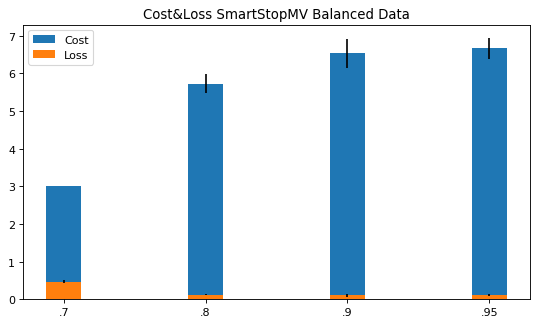

In [9]:
#smv_05 = pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')
data = pd.read_csv('./results/simulated_dataset/all_combinations_results_cr10_all.csv')
smv_05 = data[data['class_fn']=='majority_voting'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.1]


plt.figure(num=2, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.2, .4, .6, .8]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean = smv_05["cost"]/smv_05["cost_ratio"]/1000
cost_std = smv_05["cost_std"]/smv_05["cost_ratio"]/1000

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)
loss_mean = smv_05["loss"]
loss_std = smv_05["loss_std"]
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
#plt.ylabel('Cost/Loss')
plt.title('Cost&Loss SmartStopMV Balanced Data')
plt.legend((p1[0], p2[0]), ('Cost', 'Loss'))
plt.xticks(ind, ('.7', '.8','.9', '.95'))



plt.show()

In [10]:
from IPython.core import display as ICD

data = pd.read_csv('./results/simulated_dataset/all_combinations_results_mv_base.csv')
mv_base_01 = data[data['class_fn']=='majority_voting'][data['data_bal']==0.5][data['cost_ratio']==0.05][data['threshold'] in [.7,.8,.9]]

data = pd.read_csv('./results/simulated_dataset/all_combinations_results_break_tie.csv')
ba_01 = data[data['class_fn']=='majority_voting'][data['data_bal']==0.5][data['cost_ratio']==0.05][data['threshold'] in [.7,.8,.9]]

data = pd.read_csv('./results/simulated_dataset/all_combinations_results_cr10_all.csv')
smv_01 = data[data['class_fn']=='majority_voting'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.05][data['threshold'] in [.7,.8,.9]]

sem_05 = data[data['class_fn']=='truth_finder_single'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.05][data['threshold'] in [.7,.8,.9]]

#plot
datasets_print = [mv_base_01, ba_01, smv_01, sem_05]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])

    i = 2
    for _ in range(3):
        mean.append(list(datasets[2][column_mean])[i])
        std.append(list(datasets[2][column_std])[i])
        
        i += 1
    i = 2
    for _ in range(3):
        mean.append(list(datasets[3][column_mean])[i])
        std.append(list(datasets[3][column_std])[i])
        
        i += 1
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
#ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
elems = 8
ind = [1/(elems+1) * (i+1) for i in range(elems)]
width = 0.05

cost_mean, cost_std = get_approaches_results(datasets_print, "cost", "cost_std")

plt.subplot(221)

p1 = plt.bar(ind, [x/0.05/1000 for x in cost_mean], width, yerr=[x/0.05/1000 for x in cost_std])
loss_mean, loss_std = get_approaches_results(datasets_print, "loss", "loss_std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Cost')
plt.title('Approaches overall cost in units')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.07', 'STF.8', 'STF.09'))
plt.legend((p1[0], p2[0]), ('Cost', 'Loss'))
'''
plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets_print, "loss", "loss_std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.07', 'STF.8', 'STF.09'))
'''

plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets_print, "precision", "precision_std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.07', 'STF.8', 'STF.09'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets_print, "recall", "recall_std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.07', 'STF.8', 'STF.09'))

plt.show()


IndexError: list index out of range

<Figure size 1440x800 with 0 Axes>

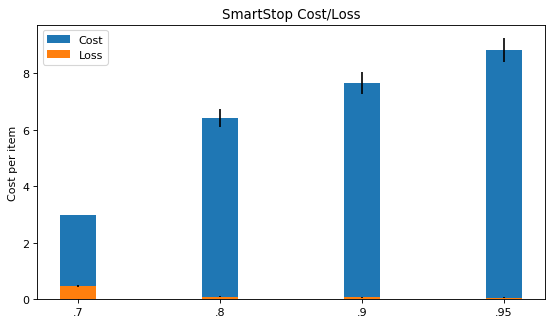

In [38]:
data = pd.read_csv('./results/simulated_dataset/all_combinations_results.csv')

bayes_mv_05 = data[data['class_fn']=='majority_voting'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.05]

bayes_tf_05 = data[data['class_fn']=='truth_finder_single'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.05]

bayes_mv_01 = data[data['class_fn']=='majority_voting'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.1]

bayes_tf_01 = data[data['class_fn']=='truth_finder_single'][data['decision_fn']=='decision_function_bayes'][data['data_bal']==0.5][data['cost_ratio']==0.1]


ths = bayes_mv['threshold']

bayes_mv_cost_05 = bayes_mv_05['cost']/bayes_mv_05['cost_ratio']/1000
bayes_mv_cost_std_05 = bayes_mv_05['cost_std']/bayes_mv_05['cost_ratio']/1000
bayes_mv_loss_05 = bayes_mv_05['loss']
bayes_mv_loss_std_05 = bayes_mv_05['loss_std']

bayes_tf_cost_05 = bayes_mv_05['cost']/bayes_mv_05['cost_ratio']/1000
bayes_tf_cost_std_05 = bayes_mv_05['cost_std']/bayes_mv_05['cost_ratio']/1000
bayes_tf_loss_05 = bayes_mv_05['loss']
bayes_tf_loss_std_05 = bayes_mv_05['loss_std']

bayes_mv_cost_05 = bayes_mv_05['precision']
bayes_mv_cost_std_05 = bayes_mv_05['precision_std']
bayes_mv_loss_05 = bayes_mv_05['loss']
bayes_mv_loss_std_05 = bayes_mv_05['loss_std']


plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
#ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
elems = 4
ind = [1/(elems+1) * (i+1) for i in range(elems)]
width = 0.05

plt.subplot(221)
p1 = plt.bar(ind, bayes_mv_cost_05, width, yerr=bayes_mv_cost_std_05)
p2 = plt.bar(ind, bayes_mv_loss_05, width, yerr=bayes_mv_loss_std_05)
plt.ylabel('Cost per item')
plt.title('SmartStop Cost/Loss')
plt.xticks(ind, ('.7','.8','.9','.95'))
plt.legend((p1[0], p2[0]), ('Cost', 'Loss'))



plt.show()


In [55]:
from IPython.core import display as ICD
data = pd.read_csv('./results/simulated_dataset/all_combinations_results.csv')

bayes_mv_05 = data[data['class_fn']=='majority_voting'][data['decision_fn']=='decision_function_bayes'][data['cost_ratio']==0.05][data['threshold']==0.95]

data = pd.read_csv('./results/abraham/results_c2_e02.csv')

abraham = data#data[data['data_bal']==0.5]

ICD.display(bayes_mv_05)
ICD.display(abraham)




loss_ratio  cost_ratio         class_fn              decision_fn  \
30           5        0.05  majority_voting  decision_function_bayes   
70           5        0.05  majority_voting  decision_function_bayes   
86           5        0.05  majority_voting  decision_function_bayes   

    data_bal  threshold     cost  cost_std   loss  loss_std  recall  \
30       0.5       0.95  441.755    21.413  0.057     0.012   0.981   
70       0.3       0.95  449.670    20.436  0.045     0.009   0.980   
86       0.1       0.95  433.325    21.522  0.029     0.008   0.985   

    recall_std  precision  precision_std  
30       0.005      0.980          0.004  
70       0.007      0.954          0.013  
86       0.014      0.819          0.018

0     1           2           3                4                 5   \
0  c     e  loss_ratio  cost_ratio         class_fn       decision_fn   
1  2  0.02           5        0.05  majority_voting  abraham_decision   
2  2  0.02           5        0.05  majority_voting  abraham_decision   
3  2  0.02           5        0.05  majority_voting  abraham_decision   

         6          7        8         9     10        11      12          13  \
0  data_bal  threshold     cost  cost_std  loss  loss_std  recall  recall_std   
1       0.5        0.5  684.988    24.775  0.01     0.006   0.995       0.004   
2       0.3        0.5  689.745    23.012  0.01     0.006   0.995       0.004   
3       0.1        0.5  687.888    24.446  0.01     0.006   0.996       0.004   

          14             15  
0  precision  precision_std  
1      0.991          0.005  
2       0.99          0.006  
3      0.989          0.005

In [270]:
datasets = [
    #{'folder':'amazon-sentiment-dataset', 'filename':'1k_amazon_reviews_crowdsourced_lemmatized_min3votes.csv','predicates': ['is_negative', 'is_book']},
    #{'folder':'loneliness-dataset-2018', 'filename':'loneliness-dataset-2018.csv','predicates': ['oa_predicate', 'study_predicate']},
    #{'folder':'ohsumed_data', 'filename':'ohsumed_C14_C23_1grams.csv','predicates': ['C14', 'C23']},
    {'folder':'BarzanMozafari', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
    #{'folder':'HyunCatherines_Binary', 'filename':'ground_truth_normalized.csv','predicates':['gt']},  
    #{'folder':'RTE', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
    #{'folder':'SpamCF', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
    #{'folder':'TEMP', 'filename':'ground_truth_normalized.csv','predicates':['gt']}, 
    #{'folder':'WVSCM', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
]

for dataset_key in range(len(datasets)):
    dataset = datasets[dataset_key]
    
    folder = dataset['folder']
    path = f'data/{folder}/workerResponses.txt'
    votes = pd.read_csv(path, delimiter='\t', header=None)
    path = f'data/{folder}/groundTruth.txt'
    ground_truth = pd.read_csv(path, delimiter='\t', header=None)
    
    workers_accuracy = []
    for worker_id in np.unique(votes[0]):
        
        worker_votes = votes[votes[0] == worker_id]
        worker_successes = 0
        worker_tasks = 0
        
        for index, worker_vote_info in worker_votes.iterrows():
            
            worker_vote_task = worker_vote_info[1]
            worker_vote = worker_vote_info[2]
            print(ground_truth[ground_truth[0]==worker_vote_task])
            
            gt_val = ground_truth[ground_truth[0]==worker_vote_task][1]
            
            if len(gt_val) > 0:
                worker_tasks += 1
                if worker_vote == gt_val.item():
                    worker_successes += 1
        #endfor
        
        if worker_tasks > 0:
            workers_accuracy.append(worker_successes / worker_tasks)
            
        break
      
        
    dataset['accuracy'] = np.mean(workers_accuracy)
        
datasets


TypeError: invalid type comparison

In [281]:
n = [3, 5]
n.index(max(n))

1

AttributeError: 'list' object has no attribute '__name__'

In [292]:
import numpy as np

#s        - number of actions
#n        - number of states
#r        - number of observations
#A[a,i,j] - probability of transition from state i to state j given action a
#O[a,j,o] - probability of observing o when entering state j given action a
#pi[j]    - probability that the initial state is j
#Act      - a list of actions
#Obs      - a list of observations, the j-th observation corresponds to the 
#           j-th action

class POMDP:
    def __init__(self, Obs, Act, A, O, pi):
        self.T = len(Obs)
        self.Obs = Obs
        self.Act = Act
        self.A = A
        self.O = O
        self.pi = pi
        self.s = self.A.shape[0]
        self.n = self.A.shape[1]
        self.r = self.O.shape[2]
        self.alpha = np.zeros((self.T+1,self.n))
        self.beta = np.zeros((self.T+1,self.n))
        self.chi = np.zeros((self.T+1,self.n))
        self.xi = np.zeros((self.T+1,self.n,self.n))

    def alpha_beta_calc(self):
        for j in range(self.n):
            self.alpha[0,j] = self.pi[j]
            self.beta[self.T,j]= 1.0            

        for t in range(1, self.T+1):
            for j in range(self.n):
                self.alpha[t,j] = sum([self.A[self.Act[t- 
                1],i,j]*self.alpha[t-1,i]*self.O[self.Act[t-1],j,self.Obs[t- 
                1]] for i in range(self.n)])
                self.beta[self.T-t,j] = sum([self.A[self.Act[self.T- 
                t],j,i]*self.O[self.Act[self.T-t],i,self.Obs[self.T- 
                t]]*self.beta[self.T- t+1,i] for i in range(self.n)])

    def xi_chi_calc(self):      
        for t in range(0, self.T+1):
            l = sum([self.alpha[t,k]*self.beta[t,k] for k in range(self.n)])

            for i in range(self.n):
                self.chi[t,i]=self.alpha[t,i]*self.beta[t,i]/l
                for j in range(self.n):
                    self.xi[t,i,j]=(self.alpha[t-1,i]*self.A[self.Act[t- 
                    1],i,j]*self.O[self.Act[t-1],j,self.Obs[t- 
                    1]]*self.beta[t,j])/l

    def pi_calc(self):
        for j in range(self.n):
            self.pi[j] = self.chi[0,j]

    def A_calc(self):        
        for i in range(self.n):
            for j in range(self.n):
                for a in range(self.s):
                    nom = sum([self.xi[t,i,j] for t in range(1,self.T+1) if 
self.Act[t-1] == a])
                    denom = sum([self.chi[t-1,i] for t in range(1,self.T+1) 
if self.Act[t-1] == a])
                    self.A[a,i,j] = nom/denom

    def O_calc(self):
        for j in range(self.n):
            for k in range(self.r):
                for a in range(self.s):
                    nom = sum([self.chi[t,j] for t in range(1, self.T+1) if 
(self.Act[t-1] == a) and (self.Obs[t-1] == k)])
                    denom = sum([self.chi[t,j] for t in range(1, self.T+1) 
if self.Act[t-1] == a])
                    self.O[a,j,k] = nom/denom
def sim(l, A, O, pi):
    obs=[]
    act=[]
    if np.random.rand()>pi[0]: curr = 1
    else: curr = 0
    states = [curr]
    for _ in range(l):
        a = np.random.randint(0,2)

        if np.random.rand()<A[a, curr, 1]: curr = 1
        else: curr = 0
        if np.random.rand()<O[a, curr, 1]: o = 1
        else: o =0
        obs.append(o)
        act.append(a)
        states.append(curr)
    return act,obs,states

def generate(length = 1000):
    A = np.random.rand(2,2,2)
    O = np.random.rand(2,2,2)
    for i in range(2):
        for j in range(2):
            A[i,j,1]=1.0-A[i,j,0]
            O[i,j,1]=1.0-O[i,j,0]

    pi = np.random.rand(2)    
    pi[1]=1.0-pi[0]
    act,obs,states = sim(length, A, O, pi)
    return A, O, pi, act,obs,states

#generate random pomdp and a simulation of a given length
A, O, pi,act,obs,states = generate(100)

#initialize matrices randomly
A, O, pi,act1,obs1,states1 = generate()
pomdp = POMDP(obs, act, A, O, pi)

for _ in range(100):
    pomdp.alpha_beta_calc()        
    pomdp.xi_chi_calc()
    pomdp.A_calc()
    pomdp.O_calc()
    pomdp.pi_calc()
    
    


In [299]:
A

array([[[0.77769904, 0.22230096],
        [0.30375983, 0.69624017]],

       [[0.19285609, 0.80714391],
        [0.00424167, 0.99575833]]])